# Convolutional neural net with pytorch (and pytorch lightning ⚡)

![](cnn.png)

* Today we will code a convolutional neural networks (CNNs), a type of neural network which is specifically well suited for dealing with images. In the previous tutorial we have seen that multilayer perceptrons present strong limitations when dealing with high dimensional inputs and in this tutorial we will see how CNNs are able to overcome these limitations

* We will be training a CNN on the FashionMNIST dataset

* We will use pytorch and pytorch-lightning and show some tools, such as the tensorboard

## Set libraries and global variables

In [1]:
#!pip install pytorch-lightning

In [2]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
import pdb
import pytorch_lightning as pl

# Import matplotlib and numpy
import numpy as np
import matplotlib.pyplot as plt

import multiprocessing

In [3]:
# Check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.8.0+cu111
0.9.0+cu111


In [4]:
num_workers = multiprocessing.cpu_count()

# Simple validation in case we have a GPU available
gpu = -1 if torch.cuda.is_available() else 0

epochs = 20

## Load the data and visualize it

In [5]:
# Use standard FashionMNIST dataset
trainset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
        #transforms.Normalize([0.5,],[0.5,])
    ])
)

validset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
        #transforms.Normalize([0.5,],[0.5,])
    ])
)

In [6]:
train_loader = DataLoader(trainset, batch_size = 64, num_workers = num_workers, shuffle=True)
valid_loader = DataLoader(validset, batch_size = 512, num_workers = num_workers)

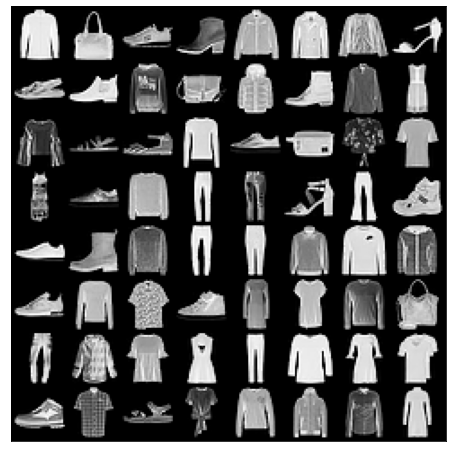

In [7]:
def show_images(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()

train_iter = iter(train_loader)
images, labels = next(train_iter)
show_images(torchvision.utils.make_grid(images))

In [8]:
class_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

np.set_printoptions(linewidth=120)
np.array([class_mapping[labels[j].item()] for j in range(64)]).reshape(8, 8)

array([['Shirt', 'Bag', 'Sneaker', 'Ankle Boot', 'Coat', 'Coat', 'Coat', 'Sandal'],
       ['Sandal', 'Ankle Boot', 'Pullover', 'Bag', 'Coat', 'Ankle Boot', 'Shirt', 'Dress'],
       ['Shirt', 'Sandal', 'Sandal', 'Pullover', 'Sneaker', 'Bag', 'Shirt', 'T-shirt/Top'],
       ['Dress', 'Sneaker', 'Shirt', 'Trouser', 'Trouser', 'Sandal', 'Trouser', 'Ankle Boot'],
       ['Sneaker', 'Ankle Boot', 'Pullover', 'Trouser', 'Trouser', 'Pullover', 'Pullover', 'Coat'],
       ['Sneaker', 'Pullover', 'Shirt', 'Sneaker', 'Dress', 'Shirt', 'Pullover', 'Bag'],
       ['Trouser', 'Coat', 'Shirt', 'Shirt', 'Trouser', 'Pullover', 'Dress', 'T-shirt/Top'],
       ['Ankle Boot', 'Shirt', 'Sandal', 'Shirt', 'Pullover', 'Coat', 'Shirt', 'Dress']], dtype='<U11')

## A CNN architecture using pytorch-lightning

Since we will use pytorch-lightning, our class needs to inherit from pl.LightningModule

### CNN Architecture

In [49]:
class FashionCNN(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        # First convolutional block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-2)

### Testing of functionality

**Pro tip.** When coding and debugging your architecture, don't use print statements to check the sizes of input / output tensors for instance. Use pdb (python debbuger) by writing the line
```python
import pdb; pdb.set_trace()
```
at the place where you want to check stuff

In [10]:
# 2 CONV + 3 FC
net = FashionCNN()
x = torch.randn(3, 1, 28, 28)
out = net(x)
out.size()

torch.Size([3, 10])

In [11]:
print(out)

tensor([[-0.2203, -0.2097, -0.1705, -0.2025,  0.1393, -0.1080, -0.2035, -0.2214,
         -0.2321, -0.5302],
        [-0.0695, -0.1547, -0.1116, -0.1441,  0.0140, -0.3365,  0.1828, -0.0830,
         -0.1374,  0.2285],
        [-0.0519, -0.4405, -0.1653, -0.3031, -0.0206, -0.0445,  0.0534, -0.0287,
         -0.3130, -0.0550]], grad_fn=<AddmmBackward>)


In [12]:
print(net)

FashionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (accuracy): Accuracy()
)


**Pro tip.** Pytorch lighting proposes many very convenient flags to try and debug before testing. For instance, `fast_dev_run` runs some training and validation steps in order to check that everyting works.

In [13]:
# Initialize a trainer
trainer = pl.Trainer(gpus=gpu, progress_bar_refresh_rate=20, fast_dev_run=True)

# Train the model ⚡
trainer.fit(net, train_dataloader=train_loader, val_dataloaders=valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 384   
1 | conv_block2 | Sequential | 18.6 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

## Tensorboard

In [25]:
from torch.utils.tensorboard import SummaryWriter
%reload_ext tensorboard

In [137]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [138]:
# get some random training images
dataiter = iter(fmnist_train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
#matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('64_fashion_mnist_images', img_grid)

In [139]:
writer.add_graph(net, images)
writer.close()

In [140]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(fmnist_train.data, fmnist_train.targets)

# get the class labels for each image
class_labels = [class_mapping[lab.item()] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [23]:
#%tensorboard --logdir=runs/

In [110]:
#%tensorboard --logdir=lightning_logs/

## Train for some epochs


In [25]:
trainer = pl.Trainer(gpus=gpu, max_epochs=epochs, progress_bar_refresh_rate=20)
trainer.fit(net, train_dataloader=train_loader, val_dataloaders=valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

In [26]:
net.accuracy.compute()

tensor(0.8163)

## Validation metrics

In [29]:
def get_predictions(model, loader):
    all_preds = torch.tensor([]).detach()
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds.detach()

In [30]:
# Note: we should increase the batch_size to compure pure forward predictions
predictions = get_predictions(net, fmnist_valid_loader)
scores = F.softmax(predictions, dim=1)

In [31]:
scores[:3].detach()

tensor([[2.6949e-12, 5.1436e-09, 2.3712e-10, 1.5349e-11, 7.8702e-11, 5.5283e-04,
         1.0564e-11, 2.8493e-03, 1.4011e-08, 9.9660e-01],
        [6.8444e-02, 1.2385e-07, 9.1769e-01, 3.0842e-04, 7.8975e-05, 1.0311e-10,
         1.3377e-02, 1.9807e-10, 1.0250e-04, 6.6828e-11],
        [2.0118e-06, 1.0000e+00, 2.1742e-08, 2.7465e-07, 7.4103e-07, 1.0553e-07,
         6.0005e-09, 2.3410e-09, 5.5077e-09, 2.4319e-10]])

In [32]:
#!pip install scikit-plot

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

cm = confusion_matrix(fmnist_valid.targets, scores.argmax(dim=1))
cm

array([[901,   4,  15,  24,   2,   1,  40,   0,  13,   0],
       [  4, 985,   0,   8,   0,   1,   0,   0,   2,   0],
       [ 49,   3, 863,  11,  28,   0,  42,   0,   4,   0],
       [ 50,  67,  14, 835,   9,   0,  23,   0,   2,   0],
       [ 11,  24, 171,  56, 583,   0, 148,   0,   7,   0],
       [  0,   1,   1,   2,   0, 952,   0,  29,   3,  12],
       [229,  11, 104,  34,  49,   0, 555,   0,  18,   0],
       [  0,   0,   0,   0,   0,   8,   0, 967,   0,  25],
       [  7,   4,   0,   5,   1,   9,  10,   6, 958,   0],
       [  0,   0,   1,   0,   0,  17,   0,  45,   0, 937]])

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

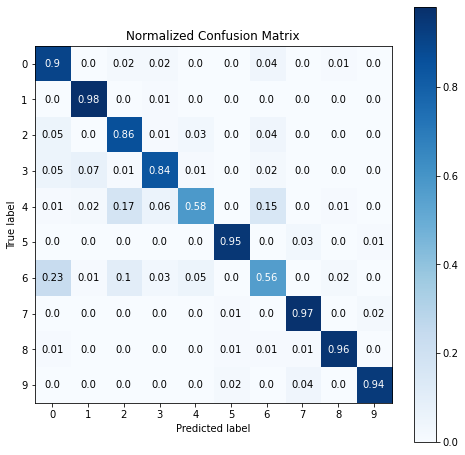

In [34]:
skplt.metrics.plot_confusion_matrix(fmnist_valid.targets, scores.argmax(dim=1), normalize=True, figsize=(8, 8))

## Your turn ! Here are some things to do

For this homework, do the following:

- Add data augmentation in the transformations used in the DataLoaders (have a look at https://github.com/zalandoresearch/fashion-mnist)
- Look for a better architecture (for instance, change padding and kernel sizes, have a look at https://github.com/zalandoresearch/fashion-mnist), try different solvers / learning rates
- Remove batch normalization, change dropout parameters, try residual connections
- It's possible to reach > 94% accuracy, once again have a look at https://github.com/zalandoresearch/fashion-mnist

### Data Augmentation

In [93]:
transformers = transforms.Compose([ 
    #transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(90, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.5,],[0.5,])
])

In [94]:
# We just make data augmentation for the training dataset
train_t = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transformers
)

In [95]:
train_t

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/FashionMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [96]:
train_loader_t = DataLoader(train_t, batch_size=64, num_workers=num_workers, shuffle=True)

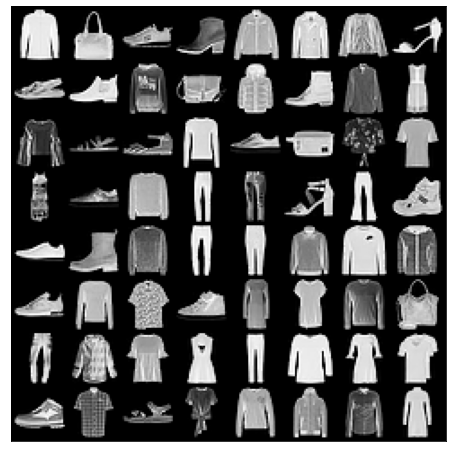

In [97]:
show_images(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


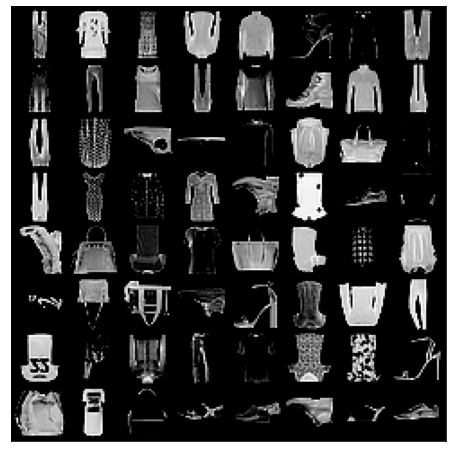

In [98]:
train_t_iter = iter(train_loader_t)
images_t, labels_t = next(train_t_iter)
show_images(torchvision.utils.make_grid(images_t))

In [99]:
net_aug = FashionCNN()
print(net_aug)

FashionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (accuracy): Accuracy()
)


In [100]:
trainer_aug = pl.Trainer(gpus=gpu, max_epochs=epochs, progress_bar_refresh_rate=20)
trainer_aug.fit(net_aug, train_dataloader=train_loader_t, val_dataloaders=valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 384   
1 | conv_block2 | Sequential | 18.6 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

In [92]:
net_aug.accuracy.compute()

tensor(0.7633)

### New Architecture